In [ ]:
import sys
sys.path.append('/home/jovyan/EngiOptiQA')

In [65]:
import os

from datetime import datetime
from engioptiqa import AnnealingSolverDWave, Rod1D, StructuralAnalysisProblem
from matplotlib import pyplot as plt
import numpy as np


In [ ]:
# Create an output folder with current time stamp.
notebook_directory = os.path.abspath("")
timestamp = datetime.now().strftime("%Y_%m_%d_%H-%M-%S")
output_path = f"{timestamp}_output"
output_path = os.path.join(notebook_directory, output_path)
os.makedirs(output_path)
output_path_dwave = os.path.join(output_path,'dwave')

# Solving a Structural Analysis Problem with EngiOptiQA

In this notebook, you can solve the structural analysis problem presented in [Key and Freinberger (2024)](https://doi.org/10.3390/math12030482) using *Quantum Annealing (QA)*.

## Suggested Steps
   1. Reproduce the results from the paper
   2. Compare with the results from Simulated Annealing (SA)
   3. Study the effect of changing 
      - the number of qubits for representig the real-valued variables (`n_qubits_per_node`)
      - the penalty weight for the constraint of static admissibility (`penalty_weight_dwave`)
      - the number of reads (`num_reads`)
      - the annealing time (`annealing_time`)
      - the chain strength (`chain_strength`)
      - ...


## The Structural Analysis Problem

In [68]:
# Define the structural analysis problem for one-dimensional rod under self-weight loading through body force density g.
g = 2.5
# Rod with n_comp components and of length L.
n_comp = 5; L = 1.5; A = 0.25; rod_1d = Rod1D(n_comp, L, A)

analysis_problem_dwave = StructuralAnalysisProblem(rod_1d, g, output_path=output_path_dwave)

Folder '/usr2/key/Projects/QuantumAnnealing/CISM/2025_04_24_14-18-54_output/dwave' created successfully.
Structural Analysis Problem



### Analytical Solution

In [69]:
# Compute analytical solution.
analysis_problem_dwave.compute_analytical_solution()

+--------------------------------+----------------------+------------------+
|         Cross Sections         | Complementary Energy |    Compliance    |
+--------------------------------+----------------------+------------------+
| (0.25, 0.25, 0.25, 0.25, 0.25) |  0.878906250000000   | 1.75781250000000 |
+--------------------------------+----------------------+------------------+

Analytic Force: [0.9375 - 0.625*x, 0.9375 - 0.625*x, 0.9375 - 0.625*x, 0.9375 - 0.625*x, 0.9375 - 0.625*x]



### Numerical Solution

#### DWave

In [ ]:
# Setup the annealing solver.
token_files = {
    'DWave': './token_DWave.txt'
    }

annealing_solver_dwave = AnnealingSolverDWave(token_files['DWave'])
annealing_solver_dwave.setup_solver(solver_type='qpu')

Available QPU solvers:
	 StructuredSolver(id='Advantage_system7.1')
	 StructuredSolver(id='Advantage_system6.4')
	 StructuredSolver(id='Advantage2_prototype2.6')
	 StructuredSolver(id='Advantage_system4.1')
Available hybrid solvers:
	 BQMSolver(id='hybrid_binary_quadratic_model_version2p')
Use qpu solver: Advantage_system4.1


#### Discretization through Real-Valued Nodal Coefficients

In [71]:
# Discretization.
binary_representation = 'normalized'
n_qubits_per_node = 10

analysis_problem_dwave.generate_discretization(n_qubits_per_node, binary_representation)

#### QUBO Formulation

In [72]:
# QUBO formulation.
penalty_weight_dwave = 2e1 # effective penalty weight
analysis_problem_dwave.generate_qubo_formulation(penalty_weight=penalty_weight_dwave)
analysis_problem_dwave.visualize_qubo_matrix_pattern(highlight_interactions=True, save_fig=False, save_tikz=False)

Effective penalty weight: 20.0

Number of input qubits: 50
Number of logical qubits: 50



#### Transform the Problem from the Amplify SDK to the DWave SDK

In [73]:
# Transform Amplify problem for DWave
lp_file_name = 'structural_analysis_problem.lp'
lp_file_path = os.path.join(output_path, lp_file_name)
analysis_problem_dwave.transform_to_dwave(lp_file_path)


#### Perform the Annealing

In [74]:
# Solve problem.
annealing_solver_dwave.solve_qubo_problem(
    analysis_problem_dwave,
    num_reads=500,
    annealing_time = 400.0,
    auto_scale = True,
    label = f"Structural Analysis Problem",
    return_embedding = False,
    chain_strength = 50
    )


Number of solutions: 500


#### Analyze the Raw Results

In [75]:
solutions_dwave = analysis_problem_dwave.analyze_results(result_max=0)

Best solution (minimum objective):
L2 Error 0.21158124373682963 0.21158124373682963
H1 Error 0.372592406601987 0.372592406601987



In [76]:
errors_l2 = [d['error_l2_rel'] for d in solutions_dwave]
errors_h1 = [d['error_h1_rel'] for d in solutions_dwave]
objectives = [d['objective'] for d in solutions_dwave]
complementary_energy = [d['complementary_energy'] for d in solutions_dwave]
complementary_energy_diff_rel = [np.abs(d['complementary_energy']-analysis_problem_dwave.PI_analytic)/np.abs(analysis_problem_dwave.PI_analytic) for d in solutions_dwave]
constraints = [d['constraints'] for d in solutions_dwave]
constraints_weighted = [penalty_weight_dwave*d['constraints'] for d in solutions_dwave]

#### Update the Penalty Weight

In [77]:
# Perform local search with adapted penalty weight.
analysis_problem_dwave.update_penalty_weight_in_qubo_formulation(penalty_weight=1.e9)
annealing_solver_dwave.perform_local_search(analysis_problem_dwave) 

Effective penalty weight: 1000000000.0



#### Analyze the Post-Processed Results

In [78]:
# Analyze post-processed results
solutions_dwave_pp = analysis_problem_dwave.analyze_results(results=analysis_problem_dwave.results_pp, result_max=0)


errors_l2_pp = [d['error_l2_rel'] for d in solutions_dwave_pp]
errors_h1_pp = [d['error_h1_rel'] for d in solutions_dwave_pp]
objectives_pp = [d['objective'] for d in solutions_dwave_pp]
complementary_energy_pp = [d['complementary_energy'] for d in solutions_dwave_pp]
complementary_energy_diff_rel_pp = [np.abs(d['complementary_energy']-analysis_problem_dwave.PI_analytic)/np.abs(analysis_problem_dwave.PI_analytic) for d in solutions_dwave_pp]
constraint_pp = [d['constraints'] for d in solutions_dwave_pp]

Best solution (minimum objective):
L2 Error 0.0009775171065493197 0.0009775171065493197
H1 Error 0.000977517106549284 0.000977517106549284



In [79]:
i_min =np.argsort(objectives_pp)
i_sol = i_min[0]
solution = solutions_dwave_pp[i_sol]
error_l2 = errors_l2_pp[i_sol]
error_h1 = errors_h1_pp[i_sol]
objective = objectives_pp[i_sol]
comp_energy_diff_rel =  complementary_energy_diff_rel_pp[i_sol]

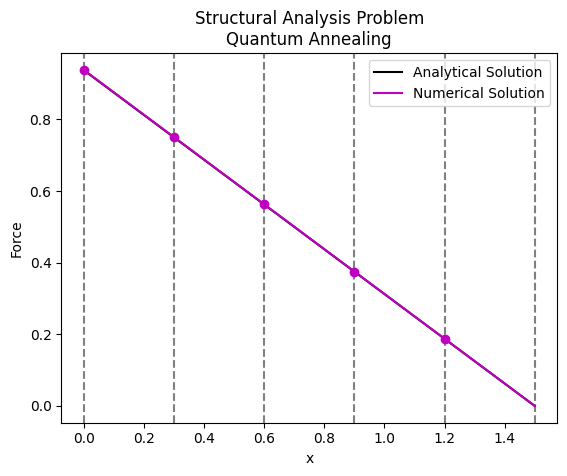

In [80]:
analysis_problem_dwave.plot_force(
    analysis_problem_dwave.force_analytic, 
    solution['force'], 
    subtitle='Quantum Annealing',
    file_name=os.path.join(output_path_dwave, 'force_quantum_annealing'),
    save_fig = True,
    save_tikz = False
) 